In [1]:

import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
import pandas as pd


In [2]:
import nltk
from nltk.tokenize import word_tokenize
# Tokenization
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:


def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

 Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s] 
Extracting Features: 100%|██████████| 249/249 [01:55<00:00,  2.16it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


In [4]:
import string
captions = pd.read_csv("/kaggle/input/datasets/adityajn105/flickr30k/captions.txt")


captions['tokens'] = captions['caption'].apply(lambda x: word_tokenize(str(x).lower()))

#captions['tokens'] = df['tokens'].apply(lambda x: ['<START>'] + x + ['<END>'])
captions['tokens'] = captions['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in string.punctuation]
)
captions['tokens'] = captions['tokens'].apply(
    lambda tokens: ['<start>'] + tokens + ['<end>']
)
captions

,image,caption,tokens
0,1000092795.jpg,Two young guys with shaggy hair look at their...,"[<start>, two, young, guys, with, shaggy, hair..."
1,1000092795.jpg,"Two young , White males are outside near many...","[<start>, two, young, white, males, are, outsi..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .,"[<start>, two, men, in, green, shirts, are, st..."
3,1000092795.jpg,A man in a blue shirt standing in a garden .,"[<start>, a, man, in, a, blue, shirt, standing..."
4,1000092795.jpg,Two friends enjoy time spent together .,"[<start>, two, friends, enjoy, time, spent, to..."
...,...,...,...
158910,998845445.jpg,A man in shorts and a Hawaiian shirt leans ov...,"[<start>, a, man, in, shorts, and, a, hawaiian..."
158911,998845445.jpg,"A young man hanging over the side of a boat ,...","[<start>, a, young, man, hanging, over, the, s..."
158912,998845445.jpg,A man is leaning off of the side of a blue an...,"[<start>, a, man, is, leaning, off, of, the, s..."
158913,998845445.jpg,"A man riding a small boat in a harbor , with ...","[<start>, a, man, riding, a, small, boat, in, ..."


In [5]:
vocab={'<pad>':0,
       '<start>':1,
       '<end>':2,
       '<UNK>':3
      }

for tokens in captions['tokens']:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)




In [6]:
len(vocab)
#preprocessing data


20279

In [7]:

def text_to_indices():
    
    numerical_sentences=[]
    for text in captions['tokens']:
        index_list=[]
        for word in text:
            index_list.append(vocab[word])
        numerical_sentences.append(index_list)
        
    return numerical_sentences
numerical_sentences=text_to_indices()

len(numerical_sentences)
        

158915

In [16]:
hidden_state=[]




max_prefix_len = 15
training_sequence = []
hidden_state = []

for img_idx, sentence in enumerate(numerical_sentences):
    if len(sentence)>16:
        continue
    for j in range(1, len(sentence)):
        
        start_idx = max(0, j - max_prefix_len)
                 
        training_sequence.append(sentence[start_idx:j])
        hidden_state.append(captions['image'][img_idx])

hidden_state[:5]


['1000092795.jpg',
 '1000092795.jpg',
 '1000092795.jpg',
 '1000092795.jpg',
 '1000092795.jpg']

In [17]:
len(training_sequence)

1280408

In [18]:
max_length=0
more=0
for sentence in training_sequence:
    if max_length< len(sentence):
        max_length=len(sentence)
    if len(sentence)>50:
        more+=1

max_length

15

In [19]:
#padding
for i in range(0,len(training_sequence)):
    training_sequence[i]=[0]*(max_length-len(training_sequence[i]))+training_sequence[i]



In [20]:
training_sequence = torch.tensor(training_sequence, dtype=torch.long)
x=training_sequence[:-50000,:-1]
y=training_sequence[:-50000,-1]
valx=training_sequence[-50000:,:-1]
valy=training_sequence[-50000:,-1]
len(x)

1230408

In [21]:
#load from the feature
import pickle

with open('/kaggle/working/flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)

print(len(features_dict))        # number of images
print(list(features_dict.keys())[:5])  # sample image names


31783
['2715746315.jpg', '3463034205.jpg', '268704620.jpg', '2673564214.jpg', '7535037918.jpg']


In [22]:
class CustomDataset(Dataset):

    def __init__(self,features,features_dict,x,y):
        self.x=x
        self.y=y
        self.features=features
        self.features_dict=features_dict

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,index):
        return self.features_dict[self.features[index]],self.x[index],self.y[index]

In [23]:
dataset=CustomDataset(hidden_state[:-50000],features_dict,x,y)

dataloader=DataLoader(dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)
val_dataset=CustomDataset(hidden_state[-50000:],features_dict,valx,valy)

val_dataloader=DataLoader(val_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

In [ ]:

class myModel(nn.Module):


    def __init__(self,vocab_size):

        super().__init__()
        self.hidden_size=512
        self.input_size=512

        self.encoder=nn.Sequential(
            nn.Linear(2048,self.hidden_size),
            nn.BatchNorm1d(self.hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_size,self.hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.3)
        )
        #self.encoder=nn.Linear(2048,self.hidden_size)
        self.embedding=nn.Embedding(vocab_size,self.input_size)
        self.lstm=nn.LSTM(self.input_size,self.hidden_size,batch_first=True,num_layers=1,dropout=0.3)
        self.finallayer=nn.Linear(512,vocab_size)

        
    def forward(self,image_features,caption):

        h0=self.encoder(image_features)
        h0=h0.unsqueeze(0)
        c0=h0

        x=self.embedding(caption)

        intermediate_hidden_states, (final_hidden_state, final_cell_state)=self.lstm(x,(h0,c0))
        output=self.finallayer(final_hidden_state.squeeze(0))
        return output

In [7]:
model=myModel(len(vocab))
model = torch.nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

epochs=7
learning_rate=0.0001
padid=0

lossfunction=nn.CrossEntropyLoss(ignore_index=padid)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [8]:
train_losses = []
val_losses = []


In [9]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for features, batchx, batchy in dataloader:
        features, batchx, batchy = features.to(device), batchx.to(device), batchy.to(device)

        optimizer.zero_grad()
        output = model(features, batchx)

        output = output.reshape(-1, len(vocab))
        batchy = batchy.reshape(-1)

        loss = lossfunction(output, batchy)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(dataloader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    val_loss_total = 0
    with torch.no_grad():
        for val_features, val_batchx, val_batchy in val_dataloader:
            val_features, val_batchx, val_batchy = val_features.to(device), val_batchx.to(device), val_batchy.to(device)
            val_output = model(val_features, val_batchx)
            val_output = val_output.reshape(-1, len(vocab))
            val_batchy = val_batchy.reshape(-1)
            val_loss = lossfunction(val_output, val_batchy)
            val_loss_total += val_loss.item()

    avg_val_loss = val_loss_total / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return F.linear(input, self.weight, self.bias)


Epoch 1, Train Loss: 3.7430, Val Loss: 3.5504
Epoch 2, Train Loss: 3.1101, Val Loss: 3.3224
Epoch 3, Train Loss: 2.8852, Val Loss: 3.2228
Epoch 4, Train Loss: 2.7376, Val Loss: 3.1726
Epoch 5, Train Loss: 2.6230, Val Loss: 3.1597
Epoch 6, Train Loss: 2.5276, Val Loss: 3.1536
Epoch 7, Train Loss: 2.4444, Val Loss: 3.1515


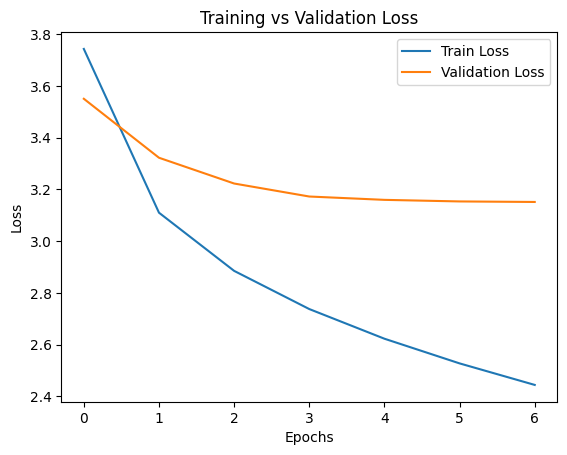

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [11]:
# Suppose 'model' is your trained PyTorch model

# 1️⃣ Save only weights (recommended)
torch.save(model.state_dict(), "model5.pth")

# 2️⃣ Save entire model (quick demo)
torch.save(model, "model5.pt")


In [12]:
# Function to calculate accuracy
def calculate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients
        for features,batch_x, batch_y in dataloader:
            features,batch_x, batch_y = features.to(device),batch_x.to(device), batch_y.to(device)

            # Get model predictions
            outputs = model(features,batch_x)

            # Get the predicted word indices
            _, predicted = torch.max(outputs, dim=1)

            # Compare with actual labels
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total * 100
    return accuracy

# Compute accuracy
accuracy = calculate_accuracy(model, val_dataloader, device)
print(f"Model Accuracy: {accuracy:.2f}%")


Model Accuracy: 41.63%
